In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_absolute_error
from scipy.stats import skew, boxcox
from math import exp, log
import os
from os import listdir
import csv
from sklearn.ensemble import RandomForestRegressor as RandomForest
%matplotlib inline
import pylab
from matplotlib.mlab import PCA as mlabPCA
import matplotlib.pyplot as plt
import math
import pickle
from sklearn.cross_validation import KFold
from sklearn import cross_validation
from sklearn import metrics

### Модель 1  Отделение 1005625
### Модель 2  Отделение 1005839
### Модель 3  Отделение 1006034
### Модель 4  Отделение 1006255
### Модель 5  Отделение 1005609


### Считываем данные

In [2]:
model1 = pd.read_csv('bracnh1_model.csv', header=0) # base8_nr900_p10¬_cleaned
model2 = pd.read_csv('bracnh2_model.csv', header=0) # base8_nr900_p10¬_cleaned
model3 = pd.read_csv('bracnh3_model.csv', header=0) # base8_nr900_p10¬_cleaned
model4 = pd.read_csv('bracnh4_model.csv', header=0) # base8_nr900_p10¬_cleaned
model5 = pd.read_csv('bracnh5_model.csv', header=0) # base8_nr900_p10¬_cleaned


### Выкидываем лишнюю колонку

In [3]:
model1 = model1.drop("bracnh1$EVENT_DTTM",axis=1)
model2 = model2.drop("bracnh2$EVENT_DTTM",axis=1)
model3 = model3.drop("bracnh3$EVENT_DTTM",axis=1)
model4 = model4.drop("bracnh4$EVENT_DTTM",axis=1)
model5 = model5.drop("bracnh5$EVENT_DTTM",axis=1)

In [4]:
model1.count = np.asarray(model1.iloc[:,0:1])
model2.count = np.asarray(model2.iloc[:,0:1])
model3.count = np.asarray(model3.iloc[:,0:1])
model4.count = np.asarray(model4.iloc[:,0:1])
model5.count = np.asarray(model5.iloc[:,0:1])

### Разбиваем на маркировку и обучающую выборку

In [5]:
train1=model1.iloc[:,1:5]
train2=model2.iloc[:,1:5]
train3=model3.iloc[:,1:5]
train4=model4.iloc[:,1:5]
train5=model5.iloc[:,1:5]
target1 = np.ravel(model1.iloc[:,0:1])
target2 = np.ravel(model2.iloc[:,0:1])
target3 = np.ravel(model3.iloc[:,0:1])
target4 = np.ravel(model4.iloc[:,0:1])
target5 = np.ravel(model5.iloc[:,0:1])

### Оценим распределение

(array([  2.58400000e+03,   1.20000000e+02,   2.49000000e+02,
          1.13000000e+02,   2.00000000e+01,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          1.00000000e+00]),
 array([   1. ,   97.9,  194.8,  291.7,  388.6,  485.5,  582.4,  679.3,
         776.2,  873.1,  970. ]),
 <a list of 10 Patch objects>)

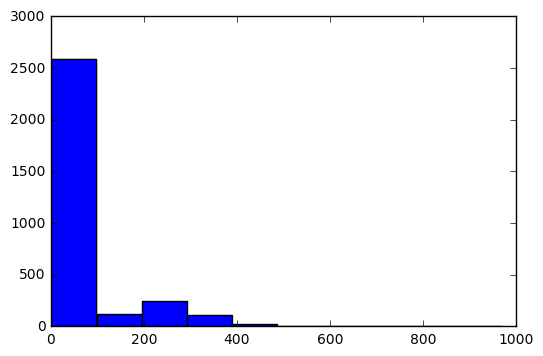

In [6]:
plt.hist(target1)

(array([  1.81700000e+03,   2.53400000e+03,   2.13100000e+03,
          1.13000000e+03,   2.98000000e+02,   7.70000000e+01,
          1.30000000e+01,   3.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([  1. ,  10.3,  19.6,  28.9,  38.2,  47.5,  56.8,  66.1,  75.4,
         84.7,  94. ]),
 <a list of 10 Patch objects>)

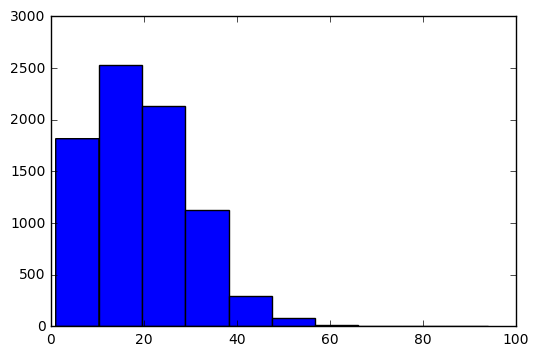

In [7]:
plt.hist(target2)

(array([  2.03600000e+03,   3.54000000e+03,   2.12200000e+03,
          5.77000000e+02,   9.90000000e+01,   1.40000000e+01,
          4.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([   1.,   16.,   31.,   46.,   61.,   76.,   91.,  106.,  121.,
         136.,  151.]),
 <a list of 10 Patch objects>)

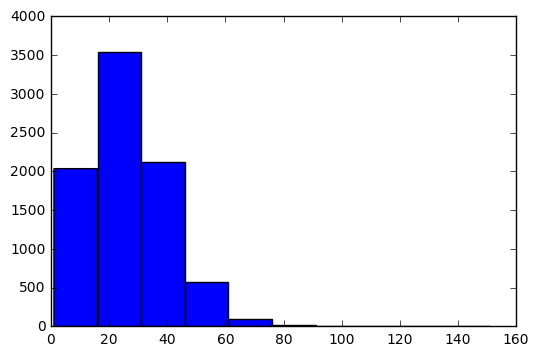

In [8]:
plt.hist(target3)

(array([ 1281.,  1427.,  1517.,  1344.,   659.,   308.,   145.,    47.,
           20.,     7.]),
 array([  1. ,   6.3,  11.6,  16.9,  22.2,  27.5,  32.8,  38.1,  43.4,
         48.7,  54. ]),
 <a list of 10 Patch objects>)

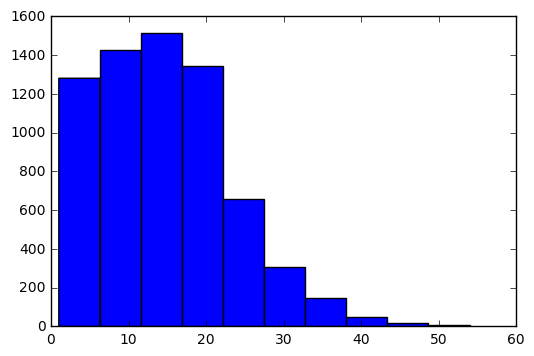

In [9]:
plt.hist(target4)

(array([  1.75000000e+03,   2.55300000e+03,   2.24200000e+03,
          1.16300000e+03,   4.13000000e+02,   1.25000000e+02,
          2.80000000e+01,   9.00000000e+00,   4.00000000e+00,
          2.00000000e+00]),
 array([   1. ,   11.2,   21.4,   31.6,   41.8,   52. ,   62.2,   72.4,
          82.6,   92.8,  103. ]),
 <a list of 10 Patch objects>)

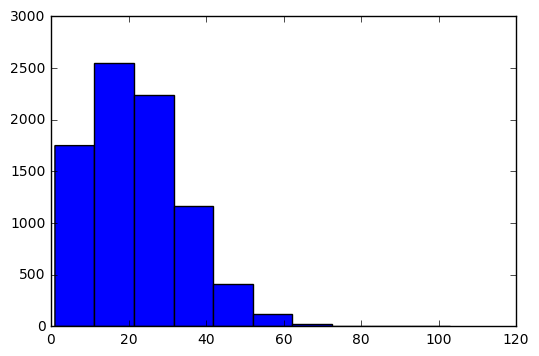

In [10]:
plt.hist(target5)

### Есть явная аномалия с первым набором образцом. Остальные можно почистить - но стоит уточнить, возможно изредка возможно такое большое количество посещений ~100. Очевидно однако, что 900 посещений в час ночи - ошибка в записи данных

### Когда происходит аномалия

In [11]:
model1_2 = model1[model1.count>140]
model1_2.Hour.value_counts() #В эти часы, причем явно это не рабочие часы

7    74
9    71
8    65
4    50
3    48
2    46
6    43
5    39
1    38
Name: Hour, dtype: int64

### Посмотрим на паттерны

In [12]:
list = []
list.append(model2)
list.append(model3)
list.append(model4)
list.append(model5)
t = np.zeros((16,1))

In [13]:
for j in list: #посчитаем количество посещаний для каждого часа
    #print '---------------------------------------'
    for i in np.arange(8,24):
            #print i,"ч.", sum(j[j.Hour==i]["count"])
            t[i-8]+=sum(j[j.Hour==i]["count"])

In [14]:
coef = np.zeros((16,2)) #посещений в час/сколько всего посещений
coef[:,0]=np.arange(8,24)
for i in np.arange(0,16):
    #print t[i]/sum(t)
    coef[i,1]=t[i]/sum(t)

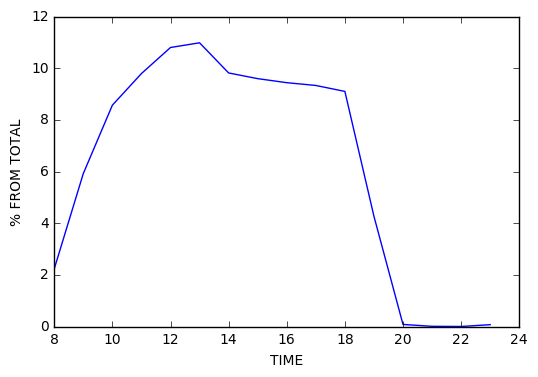

In [15]:
plt.plot(np.arange(8,24),coef[:,1]*100)
plt.xlabel('TIME')
plt.ylabel('% FROM TOTAL')

### Создадим массив c  коэффициентами для каждого часа и умножим на количество посещений в этот день

In [16]:
z=0
for i in np.arange(1,10):
    z+= len(model1[model1.Hour==i])
#sum(model1.Hour.unique()>9) # количество разных часов
x = np.zeros((z*16,5))
total = model1[model1.Hour==1] # объединим аномальные массивы где часы от 1 до 10 включительно
for i in np.arange(2,10):
    total = total.append(model1[model1.Hour==i])

In [17]:
for i in np.arange(0,z*14,16):
        x[0+i:16+i,0]=coef[:,1]#записываем коэффициенты
        x[0+i:16+i,4] = coef[:,0] #записываем часы новые

In [18]:
j=0  #количество посещений в день
for i in np.arange(0,z*14,16):
    x[0+i:16+i,0]=x[0+i:16+i,0]*total.iloc[j,0]  #количество посещений
    x[0+i:16+i,1:4]=total.iloc[j,1:4]  #год месяц день
    j+=1

In [19]:
df =pd.DataFrame(x)
df.columns=['count','Year','Month','Day','Hour']

In [20]:
new_model1 = model1[model1.Hour==10] # cjzz
for i in np.arange(11,24):
    new_model1 = new_model1.append(model1[model1.Hour==i])

In [21]:
new_model1 = new_model1.append(df)
new_model1.to_csv('task.csv', index=None)


### Данные агрегированы в R и снова загружены для построения модели

In [22]:
model1_new = pd.read_csv('bracnh1_final.csv', header=0) 
train_new=model1_new.iloc[:,1:5]
target_new = np.ravel(model1_new.iloc[:,0:1])

### Посмотрим на распределение посли очистки -  стало гораздо лучше

(array([  1.48900000e+03,   2.71600000e+03,   2.75400000e+03,
          9.02000000e+02,   2.46000000e+02,   6.00000000e+01,
          1.70000000e+01,   1.90000000e+01,   1.10000000e+01,
          2.00000000e+00]),
 array([   1.        ,   11.5524009 ,   22.1048018 ,   32.6572027 ,
          43.2096036 ,   53.7620045 ,   64.3144054 ,   74.86680629,
          85.41920719,   95.97160809,  106.52400899]),
 <a list of 10 Patch objects>)

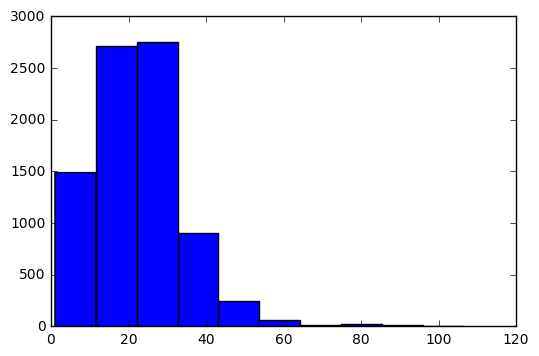

In [23]:
plt.hist(target_new,bins=10)

### Доовльно много данных где количество посещений очень маленькое

In [24]:
model1_new[model1_new['count']==1].Hour.value_counts()

18    7
20    2
15    1
17    1
Name: Hour, dtype: int64

In [25]:
model1_new.shape

(8216, 5)

### Основная масса приходится на 20-23 и 8-9. Что действительно соотвествует истине. Их можно исключить из выборки, не будем однако тратить время, на итоговый результат особого влияния они оказывать не должны

### Кросс Валидация RMSE до обработки 52 - см.ниже, после = 9

In [68]:
from sklearn.cross_validation import KFold
from sklearn import cross_validation
model = RandomForest(n_estimators=100,random_state=42)
kf = KFold(len(target_new), n_folds=5)
results= cross_validation.cross_val_predict(model, train_new, target_new, cv=kf, n_jobs=-1)
print 'RMSE for model 1   ', math.sqrt(sum((results-target_new)**2)/len(target_new))

RMSE for model 1    12.3237722705


(array([    4.,     8.,    17.,    33.,    78.,   149.,   269.,   556.,
         1010.,  1965.,  1861.,  1011.,   552.,   279.,   159.,    82.,
           39.,    27.,    30.,    19.]),
 array([-50., -45., -40., -35., -30., -25., -20., -15., -10.,  -5.,   0.,
          5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.]),
 <a list of 20 Patch objects>)

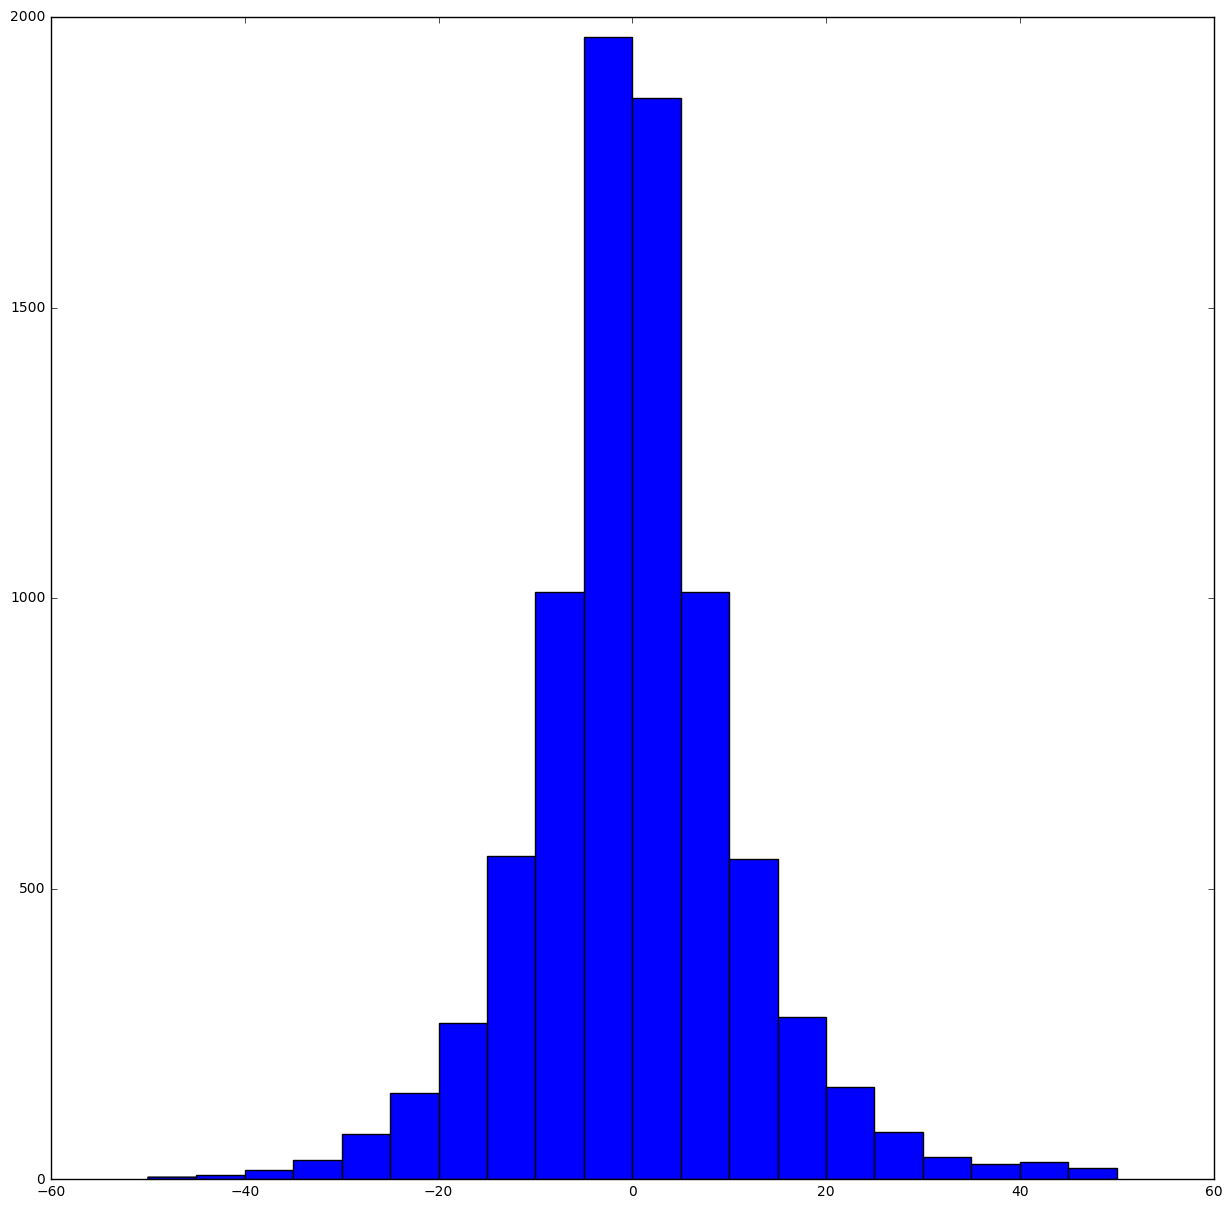

In [69]:
plt.figure(figsize=(15,15))
plt.hist(results-target_new,bins=20,range=[-50,50])

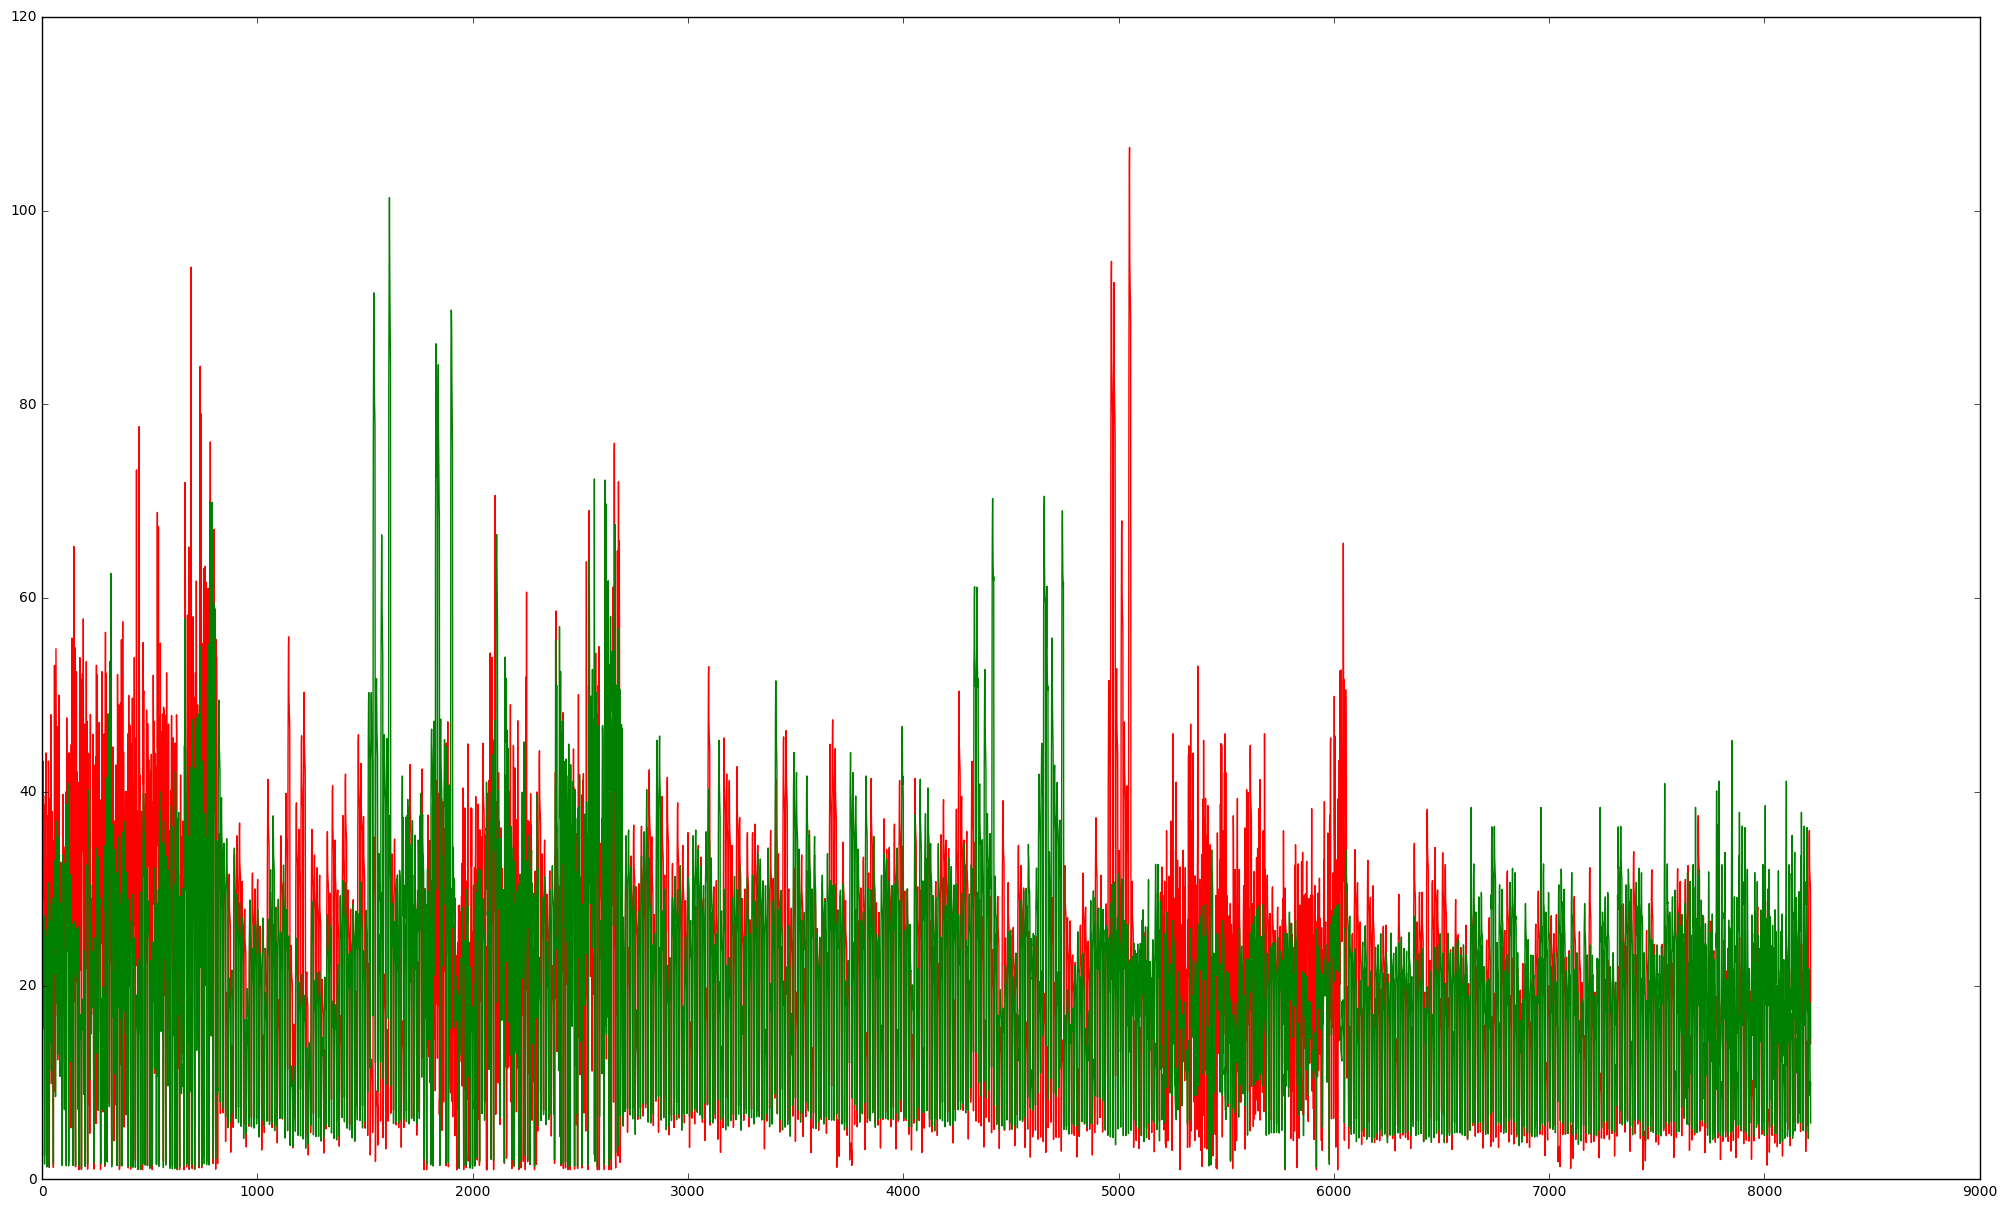

In [71]:
plt.figure(figsize=(25,15))
plt.plot(xrange(0,8216),target_new,c="r")
plt.plot(xrange(0,8216),results,c="g")


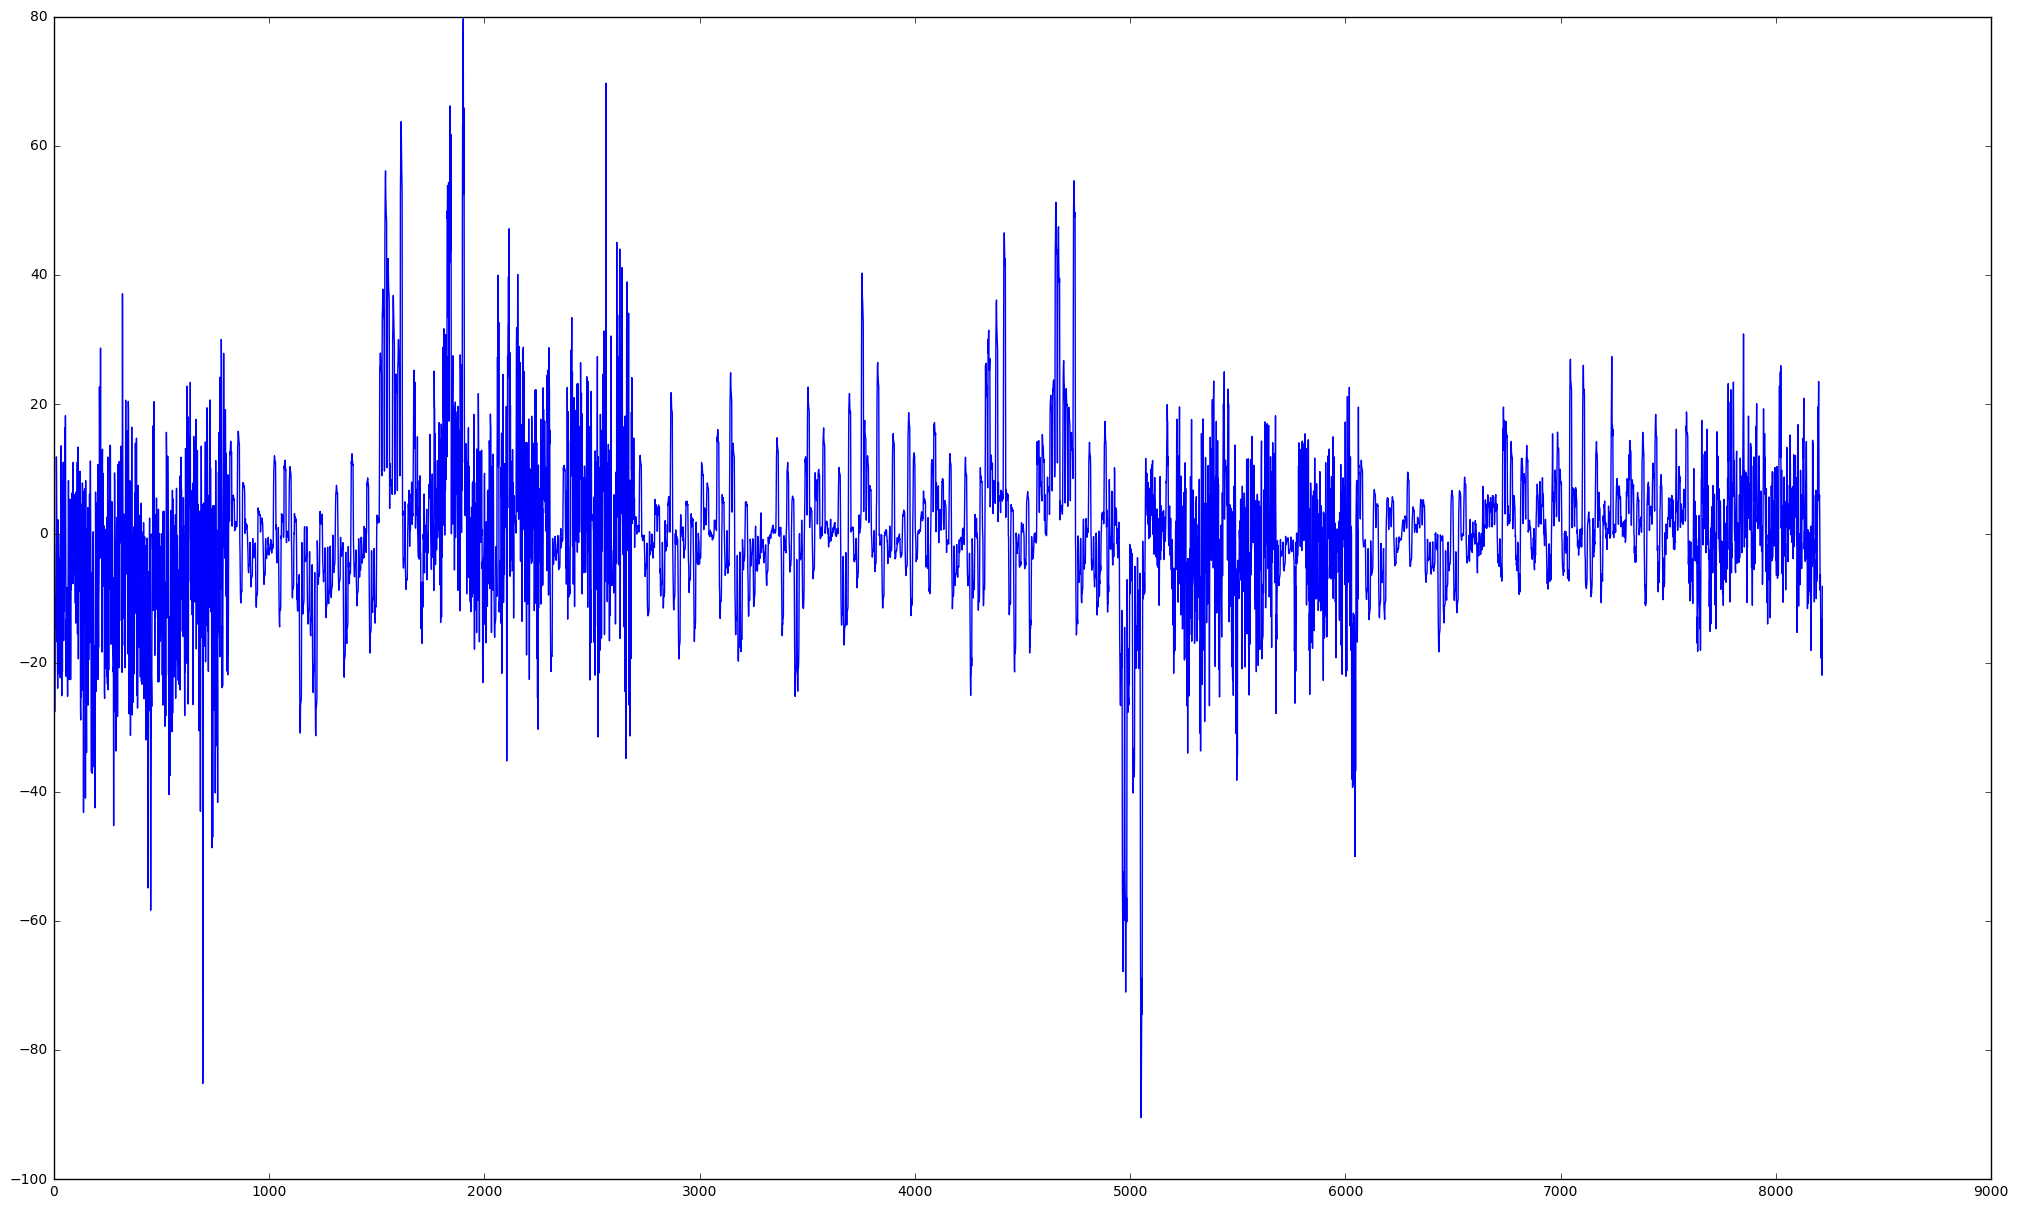

In [72]:
plt.figure(figsize=(25,15))
plt.plot(xrange(0,8216),results-target_new)

In [37]:
target_new.shape

(8216L,)

### Построим модели
### Модель rf_new  Отделение 1005625
### Модель rf2         Отделение 1005839
### Модель rf3         Отделение 1006034
### Модель rf4         Отделение 1006255
### Модель rf5         Отделение 1005609


In [28]:
rf1 = RandomForest(n_estimators=100)
rf1.fit(train1,target1)
rf2 = RandomForest(n_estimators=100)
rf2.fit(train2,target2)
rf3 = RandomForest(n_estimators=100)
rf3.fit(train3,target3)
rf4 = RandomForest(n_estimators=100)
rf4.fit(train4,target4)
rf5 = RandomForest(n_estimators=100)
rf5.fit(train5,target5)
rf_new = RandomForest(n_estimators=100)
rf_new.fit(train_new,target_new)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

### Какой прогноз дает модель на 10:00 на 15.01.2016 в отделения 1005625? А на 11:00? А на 12:00 на 16.01.2016? А на 30 декабря 2016 в 15 часов

In [60]:
rf_new = RandomForest(n_estimators=100,max_depth=20)
rf_new.fit(train_new,target_new)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [62]:
x = np.array([[2016,1,15,10],[2016,1,15,11],[2016,1,16,11],[2016,12,30,15]])
rf_new.predict(x)

array([ 22.71235903,  26.07429876,  24.10918602,  58.29784785])

In [31]:
x

array([[2016,    1,   15,   10],
       [2016,    1,   15,   11],
       [2016,    1,   16,   11],
       [2016,   12,   30,   15]])

 ###  Подсчитаем расхождения если не чистить модели. Теоретически случайный лес не переобучается выше определенного, некритического предела

In [32]:
res1 = rf1.predict(train1)- target1
res2 = rf2.predict(train2)- target2
res3 = rf3.predict(train3)- target3
res4 = rf4.predict(train4)- target4
res5 = rf5.predict(train5)- target5

### Подсчитаем метрику RMSE в целом

In [33]:
RMSE1 = math.sqrt(sum(res1**2)/len(target1))
RMSE2 = math.sqrt(sum(res2**2)/len(target2))
RMSE3 = math.sqrt(sum(res3**2)/len(target3))
RMSE4 = math.sqrt(sum(res4**2)/len(target4))
RMSE5 = math.sqrt(sum(res5**2)/len(target5))

In [34]:
print "RMSE 1 withouth preprocessing  ",RMSE1,"RMSE 2  ",RMSE2,"RMSE 3  ",RMSE3,"RMSE 4  ",RMSE4,"RMSE 5  ",RMSE5

RMSE 1 withouth preprocessing   13.4535247997 RMSE 2   3.59345788034 RMSE 3   4.30874561657 RMSE 4   2.90061254921 RMSE 5   4.03442243681


### Кросс Валидация

In [35]:
model = RandomForest(n_estimators=100,random_state=42)
kf = KFold(len(target1), n_folds=5)
results= cross_validation.cross_val_predict(model, train1, target1, cv=kf, n_jobs=-1)
print 'RMSE for model 1 old   ', math.sqrt(sum((results-target1)**2)/len(target1))
kf = KFold(len(target2), n_folds=5)
results= cross_validation.cross_val_predict(model, train2, target2, cv=kf, n_jobs=-1)
print 'RMSE for model 2   ', math.sqrt(sum((results-target2)**2)/len(target2))
kf = KFold(len(target3), n_folds=5)
results= cross_validation.cross_val_predict(model, train3, target3, cv=kf, n_jobs=-1)
print 'RMSE for model 3   ', math.sqrt(sum((results-target3)**2)/len(target3))
kf = KFold(len(target4), n_folds=5)
results= cross_validation.cross_val_predict(model, train4, target4, cv=kf, n_jobs=-1)
print 'RMSE for model 4   ', math.sqrt(sum((results-target4)**2)/len(target4))
kf = KFold(len(target5), n_folds=5)
results= cross_validation.cross_val_predict(model, train5, target5, cv=kf, n_jobs=-1)
print 'RMSE for model 5   ', math.sqrt(sum((results-target5)**2)/len(target5))

RMSE for model 1 old    52.5582954161
RMSE for model 2    10.3522353101
RMSE for model 3    14.0110998248
RMSE for model 4    8.80988924433
RMSE for model 5    12.3545288355


### Если посмотреть на гистограммы распределений и RMSE моделей видно, что RMSE больше именно там, где присуствутют выбросы с аномально высоким количеством посещений в час. Однако прежде чем их удалять, следует проконсультироваться с бизнесом и понять причину: ошибка записи? Специфичный наплыв клиентво именно в эти дни? Ошибка не столь явно выражение как в отделении  1005625 . Скорее всего,  если убрать  выбросы, можно улучшить метрику на 2-3 пункта и сделать равной отделению 1006255 и 1005625 после очистки  . Но повторяюсь, нужно понимать их причину

### Сохраняем модели

In [36]:
#pickle.dump(rf_new,open('1005625.pkl','wb'))
#pickle.dump(rf2,open('1005839.pkl','wb'))
#pickle.dump(rf3,open('1006034.pkl','wb'))
#pickle.dump(rf4,open('1006255.pkl','wb'))
#pickle.dump(rf5,open('1005609.pkl','wb'))
#pickle.dump(rf1,open('1005609_with_outliers.pkl','wb'))
